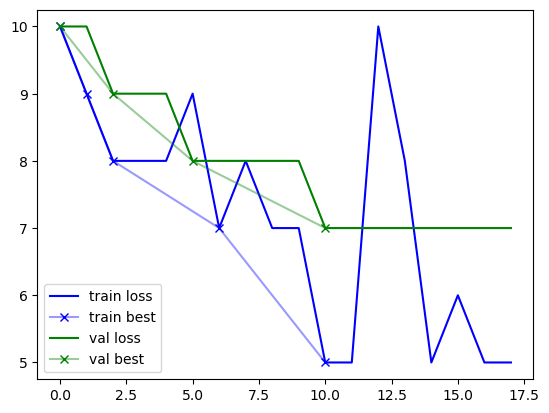

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

train_losses = np.array([10, 9, 8, 8, 8, 9, 7, 8, 7, 7, 5, 5, 10, 8, 5, 6, 5, 5])
losses_minimum = np.minimum.accumulate(train_losses)
change_indices = (np.roll(losses_minimum, 1) != losses_minimum).nonzero()[0]
best_losses = train_losses[change_indices]
val_losses = np.array([10, 10, 9, 9, 9, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7])
val_losses_minimum = np.minimum.accumulate(val_losses)
val_change_indices = (np.roll(val_losses_minimum, 1) != val_losses_minimum).nonzero()[0]
best_val_losses = val_losses[val_change_indices]

train_l, = plt.plot(train_losses, color='blue', label="loss")
train_mark, = plt.plot(change_indices, best_losses, color='blue', marker='x', linestyle='None')
train_lin,  = plt.plot(change_indices, best_losses, color='blue', linestyle='-', alpha=0.4)
val_l, = plt.plot(val_losses, color='green', label="val loss")
val_mark, = plt.plot(val_change_indices, best_val_losses, color='green', marker='x', linestyle='None')
val_lin,  = plt.plot(val_change_indices, best_val_losses, color='green', linestyle='-', alpha=0.4)
plt.legend([train_l, (train_mark, train_lin), val_l, (val_mark, val_lin)], ['train loss', 'train best', 'val loss', 'val best'], loc='lower left')
plt.show()

In [16]:
def compute_pixel_loss(m: int) -> int:
    return 4 * m * (512 - m)

for m in [1, 2, 4, 8, 16, 24]:
    pixels_lost = compute_pixel_loss(m)
    percentage = pixels_lost / (512 * 512) * 100
    print(f"m={m}: pixels lost = {pixels_lost}, percentage = {percentage:.2f}%")

m=1: pixels lost = 2044, percentage = 0.78%
m=2: pixels lost = 4080, percentage = 1.56%
m=4: pixels lost = 8128, percentage = 3.10%
m=8: pixels lost = 16128, percentage = 6.15%
m=16: pixels lost = 31744, percentage = 12.11%
m=24: pixels lost = 46848, percentage = 17.87%


In [3]:
# Group checkpoints into folders
import glob
import os
import re


def get_run_name(path: str) -> str:
    # Remove "_best", "_epoch_*"
    name = os.path.basename(path)
    name = re.sub(r"_best.pt", "", name)
    name = re.sub(r"_epoch_\d+\.pt", "", name)
    return name


paths = glob.glob(os.path.join("../save/checkpoints/*.pt"))
for path in paths:
    run_name = get_run_name(path)
    dir_name = os.path.join("../save/checkpoints", run_name)
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    os.rename(path, os.path.join(dir_name, os.path.basename(path)))

In [20]:
%load_ext autoreload
%autoreload 2

from src.deep_ad.config import Config

config = Config(root_dir="..", config_path="../default_config.yml")

config.batch_size = 64
config.train_epochs = 100
config.loss_type = "l1_norm"
config.init_weights = True
config.optim_lr = 2e-4

run_name = "8_class_10_1_batch_100_epochs_l1_norm_batch_64"
config.save(f"../save/checkpoints/{run_name}/config.yml")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from src.deep_ad.config import Config
from src.deep_ad.image import plot_losses
from src.deep_ad.model import DeepCNN
from src.deep_ad.save_manager import SaveManager
from src.deep_ad.trainer import create_optimizer

config = Config(root_dir="..", config_path="../default_config.yml")
save_manager = SaveManager(config)

model_best = DeepCNN(config, old_architecture=False).to(config.device)
optimizer_best = create_optimizer(model_best, config)
run_name = "test"
checkpoint_name = "epoch_100"
model_best, optimizer_best, train_losses, val_losses, epoch = SaveManager.load_checkpoint(
    model=model_best,
    optimizer=optimizer_best,
    path=SaveManager.get_checkpoint_path(config, run_name=run_name, name=checkpoint_name),
)
plot_losses(train_losses, val_losses, f"{run_name}/{checkpoint_name}")

In [6]:
# How many test labels are there? + Group per each class
import glob
import os

from src.deep_ad.config import Config

config = Config(root_dir="..", config_path="../default_config.yml")
classes = list(range(1, 11))
total_labels = 0
for cls in classes:
    class_paths = os.path.join(config.DAGM_raw_dir, f"Class{cls}", "Test", "Label", "*.PNG")
    num_labels = len(glob.glob(class_paths))
    total_labels += num_labels
    print(f"Class {cls}: {num_labels} labels")
print(f"Total labels: {total_labels}")

Class 1: 71 labels
Class 2: 84 labels
Class 3: 84 labels
Class 4: 68 labels
Class 5: 80 labels
Class 6: 67 labels
Class 7: 150 labels
Class 8: 150 labels
Class 9: 150 labels
Class 10: 150 labels
Total labels: 1054


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
10_0045
{'10_0013': 'C:\\Stefan\\Facultate\\Licenta\\Datasets\\DAGM\\Class10\\Test\\Label\\0013_label_better.png', '10_0020': 'C:\\Stefan\\Facultate\\Licenta\\Datasets\\DAGM\\Class10\\Test\\Label\\0020_label_better.png'}
C:\Stefan\Facultate\Licenta\Datasets\DAGM\Class10\Test\Label\0045_label.PNG


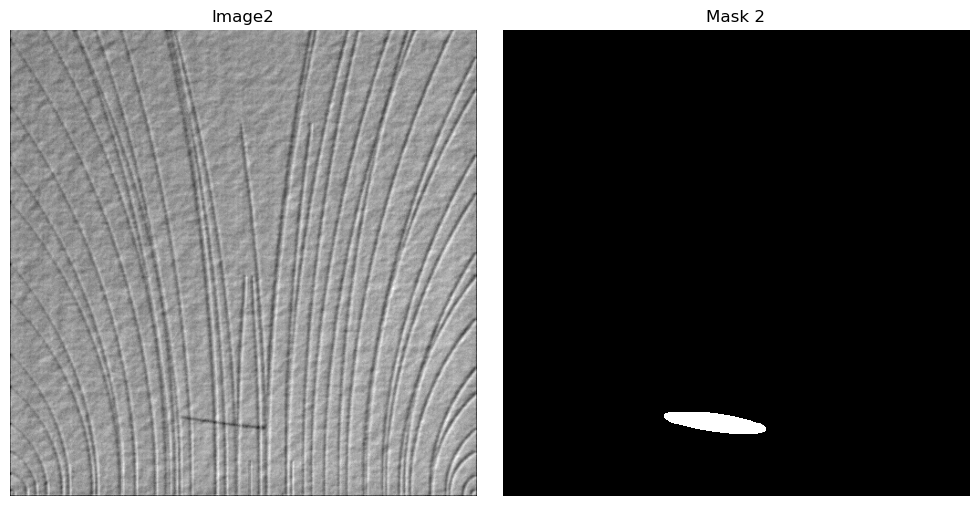

In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from src.deep_ad.config import Config
from src.deep_ad.data.dagm_dataset import DAGMDataset
from src.deep_ad.image import plot_images
from src.deep_ad.transforms import create_test_transform

config = Config(root_dir="..", config_path="../default_config.yml")
test_dataset = DAGMDataset(
    config.DAGM_raw_dir, transform=create_test_transform(), classes=[10], type="Defect-only", train=False
)
idx = 2
image, image_label_better = test_dataset[idx]
image, image_label_better = image.squeeze(), image_label_better.squeeze()
plot_images([image, image_label_better], [f"Image{idx}", f"Mask {idx}"], rows=1, cols=2, figsize=(10, 5))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


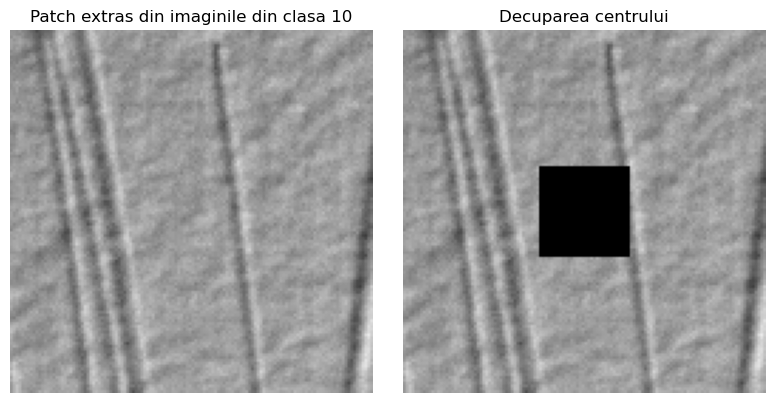

In [11]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt

from src.deep_ad.config import Config
from src.deep_ad.data.dagm_dataset import DAGMPatchDataset
from src.deep_ad.data.dagm_utils import dagm_get_patches_dir
from src.deep_ad.image import plot_images
from src.deep_ad.transforms import create_validation_transform
from src.deep_ad.trainer import create_center_mask

config = Config(root_dir="..", config_path="../default_config.yml")
patches_dir = dagm_get_patches_dir(
    config,
    ppi=config.ppi,
    patch_size=config.raw_patch_size,
    pad=config.patches_pad,
    name=config.patches_dataset_name,
)
test_dataset = DAGMPatchDataset(patches_dir, transform=create_validation_transform(config), classes=[10])
idx = 2
image, _ = test_dataset[idx]
image = image.squeeze()
mask = create_center_mask()
input_image = image * (1 - mask)
plot_images([image, input_image], [f"Patch extras din imaginile din clasa {10}", f"Decuparea centrului"], rows=1, cols=2, figsize=(8, 4), show=False)
plt.savefig("./cut_patch_center.pdf", bbox_inches='tight')
plt.show()

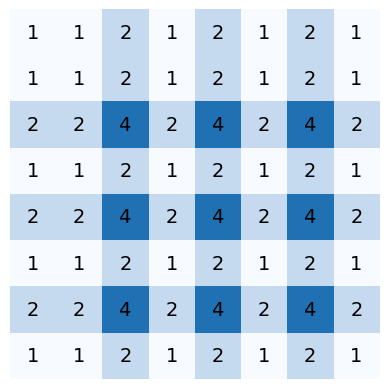

In [38]:
import matplotlib.pyplot as plt
import numpy as np

img_size = 8
patch_size = 3
stride = 2
img = np.zeros((img_size, img_size))
fig, ax = plt.subplots()
for i in range(0, img_size - patch_size + 1):
    for j in range(0, img_size - patch_size + 1):
        img[i*stride:i*stride + patch_size, j*stride:j*stride + patch_size] += 1
ax.axis("off")
ax.matshow(img, cmap=plt.cm.Blues, vmin=1, vmax=5)
for i in range(img_size):
    for j in range(img_size):
        ax.text(i, j, str(int(img[i, j])), va="center", ha="center", fontsize=14)
plt.savefig("./patch_overlap.pdf", bbox_inches='tight')
plt.show()

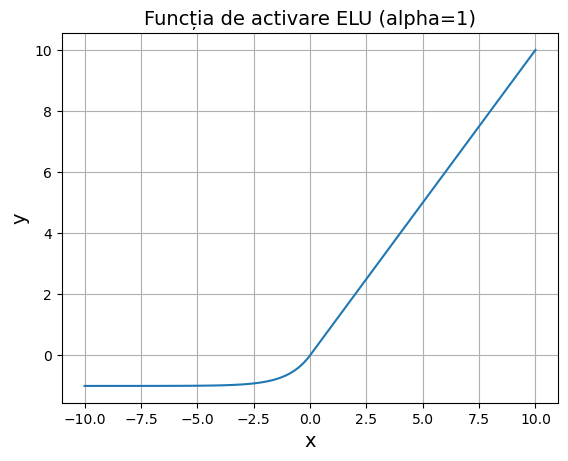

In [10]:
import numpy as np
import matplotlib.pyplot as plt

alpha = 1
xs = np.linspace(-10, 10, 100)
ys = np.zeros_like(xs)
ys[xs < 0] = alpha * (np.exp(xs[xs < 0]) - 1)
ys[xs >= 0] = xs[xs >= 0]
plt.plot(xs, ys)
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.grid(True)
plt.title(f"Funcția de activare ELU (alpha={alpha})", fontsize=14)
plt.savefig("./elu.pdf", bbox_inches="tight")
plt.show()

C:\Users\popas\AppData\Local\Temp\ipykernel_19576\4269822806.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["-1", "0", "1"])


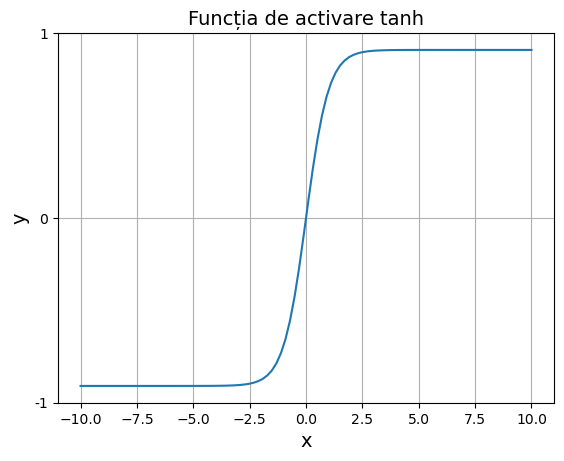

In [22]:
import numpy as np
import matplotlib.pyplot as plt

alpha = 1
xs = np.linspace(-10, 10, 100)
ys = np.zeros_like(xs)
ys = (np.exp(xs) - np.exp(-xs)) / (np.exp(xs) + np.exp(-xs))
fig, ax = plt.subplots()
plt.plot(xs, ys)
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.grid(True)
plt.title(f"Funcția de activare tanh", fontsize=14)
plt.savefig("./tanh.pdf", bbox_inches="tight")
plt.yscale("symlog")
ax.set_yticklabels(["-1", "0", "1"])
plt.show()

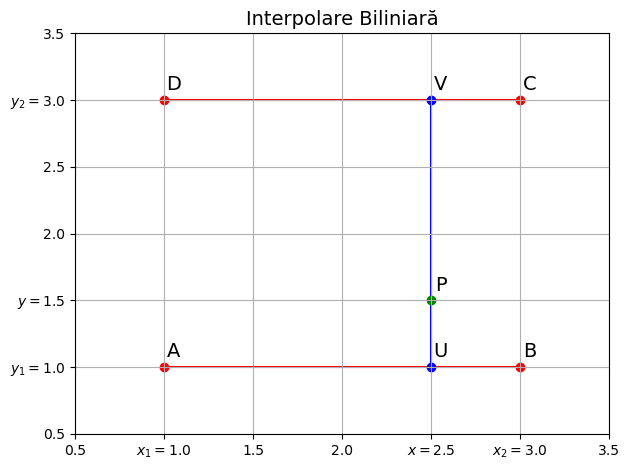

In [55]:
import matplotlib.pyplot as plt

# Bilinear interpolation demo
fig, ax = plt.subplots()
plt.scatter([1, 3, 3, 1], [1, 1, 3, 3], color="red")
plt.scatter([2.5, 2.5], [1, 3], color="blue")
plt.scatter([2.5], [1.5], color="green")
plt.xlim(0.5, 3.5)
plt.ylim(0.5, 3.5)
plt.xticks([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5], ["0.5", "$x_1=1.0$", "1.5", "2.0", "$x=2.5$", "$x_2=3.0$", "3.5"])
plt.yticks([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5], ["0.5", "$y_1=1.0$", "$y=1.5$", "2.0", "2.5", "$y_2=3.0$", "3.5"])
plt.plot([1, 3], [1, 1], color="red", zorder=0)
plt.plot([1, 3], [3, 3], color="red", zorder=0)
plt.plot([2.5, 2.5], [1, 3], color="blue", zorder=0)
plt.annotate("A", (1, 1), textcoords="offset points", xytext=(7, 7), ha="center", zorder=1, fontsize=14)
plt.annotate("B", (3, 1), textcoords="offset points", xytext=(7, 7), ha="center", zorder=1, fontsize=14)
plt.annotate("C", (3, 3), textcoords="offset points", xytext=(7, 7), ha="center", zorder=1, fontsize=14)
plt.annotate("D", (1, 3), textcoords="offset points", xytext=(7, 7), ha="center", zorder=1, fontsize=14)
plt.annotate("U", (2.5, 1), textcoords="offset points", xytext=(7, 7), ha="center", zorder=1, fontsize=14)
plt.annotate("V", (2.5, 3), textcoords="offset points", xytext=(7, 7), ha="center", zorder=1, fontsize=14)
plt.annotate("P", (2.5, 1.5), textcoords="offset points", xytext=(7, 7), ha="center", zorder=1, fontsize=14)
plt.grid(True)
plt.title("Interpolare Biliniară", fontsize=14)
plt.tight_layout()
plt.savefig("./bilinear_interpolation.pdf", bbox_inches="tight")

Save masks for each class

In [15]:
from src.deep_ad.config import Config
from src.deep_ad.data.dagm_dataset import DAGMDatasetDev
from src.deep_ad.data.dagm_utils import dagm_build_key
from src.deep_ad.save_manager import SaveManager
from src.deep_ad.transforms import create_test_transform

config = Config(root_dir="..", config_path="../default_config.yml")
save_manager = SaveManager(config)

image_class = 10
test_transform = create_test_transform()
test_dataset = DAGMDatasetDev(
    img_dir=config.DAGM_raw_dir,
    transform=test_transform,
    target_transform=test_transform,
    classes=[image_class],
    type="Defect-only",
    train=False,
)

image_masks = []
for image, image_label_better, image_class, image_name in test_dataset:
    image_key = dagm_build_key(str(image_class), image_name)
    image_label_better = image_label_better.squeeze()
    image_masks.append(image_label_better)

save_manager.save_image_masks(image_class, image_masks)
image_masks = save_manager.load_masks(image_class)
print(f"Image masks shape: {image_masks.shape}")

Masks saved at '..\save\masks\class_10.pt'.
Image masks shape: torch.Size([150, 512, 512])


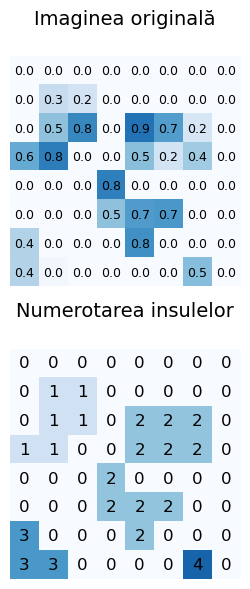

In [63]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.ndimage import label as scipy_label

fig = plt.figure(figsize=(3, 6))

mat = np.array([[0, 0, 0, 0, 0, 0, 0, 0],
                [0, 1, 1, 0, 0, 0, 0, 0],
                [0, 1, 1, 0, 1, 1, 1, 0],
                [1, 1, 0, 0, 1, 1, 1, 0],
                [0, 0, 0, 1, 0, 0, 0, 0],
                [0, 0, 0, 1, 1, 1, 0, 0],
                [1, 0, 0, 0, 1, 0, 0, 0],
                [1, 1, 0, 0, 0, 0, 1, 0]], dtype=np.uint8)

image_mat = np.zeros_like(mat, dtype=np.float32)
for i in range(8):
    for j in range(8):
        image_mat[i, j] = np.random.random() * mat[i, j]
ax = plt.subplot(2, 1, 1)
ax.axis("off")
ax.matshow(image_mat, cmap=plt.cm.Blues, vmin=0, vmax=1.2)
for i in range(8):
    for j in range(8):
        ax.text(j, i, f"{image_mat[i, j]:.1f}", va="center", ha="center", fontsize=9)
plt.title("Imaginea originală", fontsize=14)


ax = plt.subplot(2, 1, 2)
labels, num_labels = scipy_label(mat, structure=np.ones((3, 3)))
ax.axis("off")
ax.matshow(labels, cmap=plt.cm.Blues, vmin=0, vmax=num_labels + 1)
for i in range(8):
    for j in range(8):
        ax.text(j, i, str(labels[i, j]), va="center", ha="center", fontsize=12)
plt.title("Numerotarea insulelor", fontsize=14)

plt.tight_layout()
plt.savefig("./label_islands.pdf", bbox_inches="tight")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


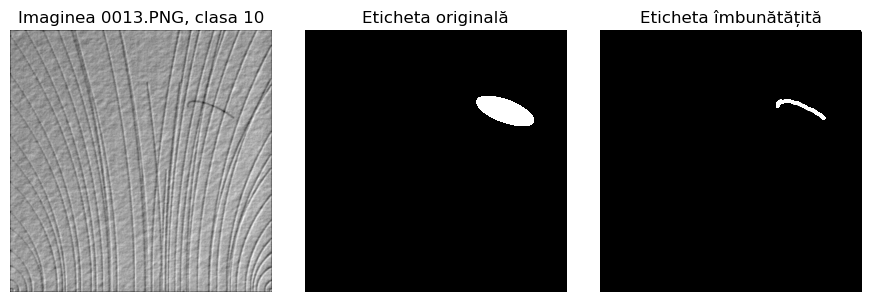

In [11]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt

from src.deep_ad.config import Config
from src.deep_ad.data.dagm_dataset import DAGMDatasetDev
from src.deep_ad.image import plot_images
from src.deep_ad.transforms import create_test_transform

config = Config(root_dir="..", config_path="../default_config.yml")
idx = 0
test_dataset = DAGMDatasetDev(
    config.DAGM_raw_dir, transform=create_test_transform(), classes=[10], type="Defect-only", train=False, use_better_labels=True
)
image, image_label_better, image_cls, image_name = test_dataset[idx]
image, image_label_better = image.squeeze(), image_label_better.squeeze()

test_dataset = DAGMDataset(
    config.DAGM_raw_dir, transform=create_test_transform(), classes=[10], type="Defect-only", train=False, use_better_labels=False
)
image, image_label = test_dataset[idx]
image, image_label = image.squeeze(), image_label.squeeze()
plot_images([image, image_label, image_label_better], [f"Imaginea {image_name}.PNG, clasa {image_cls}", f"Eticheta originală", "Eticheta îmbunătățită"], rows=1, cols=3, figsize=(9, 3), show=False)
plt.savefig("./better_labels.pdf", bbox_inches="tight")